# Group-level satistical analysis of brain electrical properties - Experiment n°1
This notebook presents the first experiment of the group level statistical analysis of brain electrical properties ($\sigma$ and $\epsilon_r$). From the processed neonatal, infant and children data, we rejected outlier sessions that showed poor electrical properties (EPs) reconstruction due to misregistration of the brain mask or higher levels of noise and motion artefacts. In total, $868$ neonates, $13$ infants and $46$ children scans were included in this analysis. We performed statistical analysis at the group level by extracting the median EPs over the eroded brain ROI of each subject. We used the median values as they tend to be more robust to the effect of EP outlier voxels due to misregistration or discontinuities.

Part of nano-eptk package by Arnaud Boutillon (arnaud.boutillon@kcl.ac.uk).

## Python environment setting

In [1]:
import os
import sys
import warnings

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from scipy.stats import ttest_ind

base_dir = os.path.abspath(os.path.join(os.path.pardir, os.path.pardir))
sys.path.append(os.path.join(base_dir))

from utils.stats import *
from utils.plots import *

sns.set_theme(style="darkgrid")
warnings.filterwarnings("ignore")

## 1. Comparison of neonatal, infants and children GRE brain EPs

Brain EPs of neonates ($n = 868$), infants ($n = 13$) and children ($n = 46$) from GRE measurements were compared statistically using the unpaired Welch's *t*-test with Bonferroni correction to account for multiple comparisons.

In [2]:
def load_GRE_dfs():
    # Set file path
    dHCP_df_path = os.path.join(csv_dir, "dHCP_GRE.csv")
    BIBS_df_path = os.path.join(csv_dir, "BIBS.csv")
    RICE_df_path = os.path.join(csv_dir, "RICE.csv")

    # Load datafranes
    dHCP_df = pd.read_csv(dHCP_df_path)
    BIBS_df = pd.read_csv(BIBS_df_path)
    RICE_df = pd.read_csv(RICE_df_path)

    # Display cohort sizes
    print(f"dHCP sessions n = {len(dHCP_df.index)}")
    print(f"dHCP subjects m = {dHCP_df['subject_id'].nunique()}")
    print(f"BIBS sessions n = {len(BIBS_df.index)}")
    print(f"BIBS subjects m = {BIBS_df['subject_id'].nunique()}")
    print(f"RICE sessions n = {len(RICE_df.index)}")
    print(f"RICE subjects m = {RICE_df['subject_id'].nunique()}")

    # Constants
    week_in_years = 1 / 52.25
    month_in_years = 1 / 12
    gestational_weeks = 40
        
    # Convert age to years
    dHCP_df[age_col] = (dHCP_df["PMA"] - gestational_weeks) * week_in_years
    BIBS_df[age_col] = BIBS_df[age_col] * month_in_years

    # Select relevant columns
    dHCP_df = dHCP_df[[age_col, sig_col, eps_col]]
    BIBS_df = BIBS_df[[age_col, sig_col, eps_col]]
    RICE_df = RICE_df[[age_col, sig_col, eps_col]]
    
    # Assign cohort labels
    dHCP_df[cohort_col] = "neonates"
    BIBS_df[cohort_col] = "infants"
    RICE_df[cohort_col] = "children"

    return pd.concat([dHCP_df, BIBS_df, RICE_df], ignore_index=True)

dHCP sessions n = 868
dHCP subjects m = 770
BIBS sessions n = 13
BIBS subjects m = 11
RICE sessions n = 77
RICE subjects m = 57


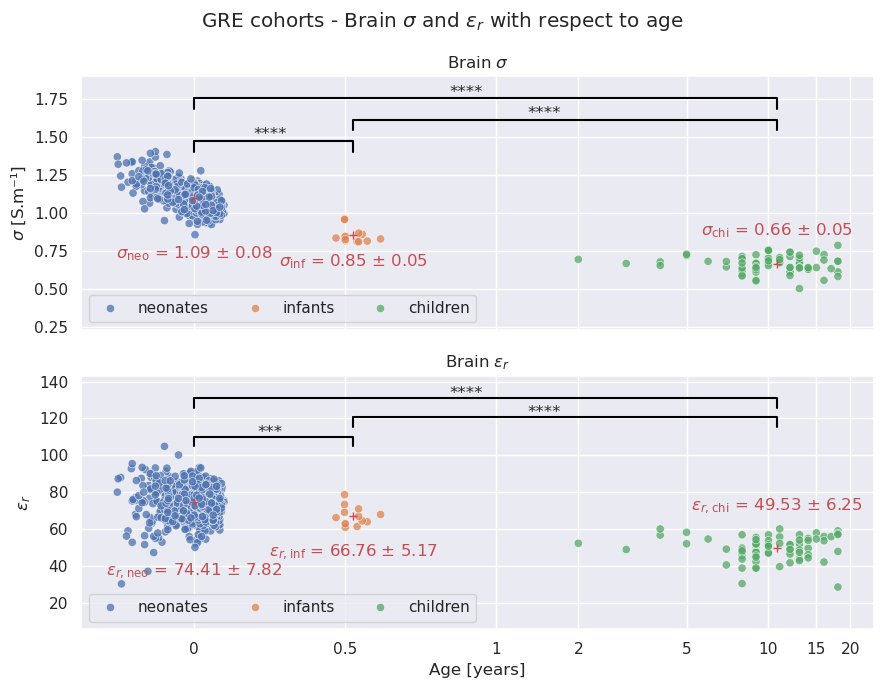

In [3]:
# Set directories
csv_dir = os.path.join(base_dir, "data", "cohorts_csv")
plot_dir = os.path.join(base_dir, "plots", "experiments")

# Set file path
plot_path = os.path.join(plot_dir, "experiment1A.png")

# Data headers
age_col = "age"
sig_col = "GRE_SIG"
eps_col = "GRE_EPS"
cohort_col = "cohort"

# Load data
df = load_GRE_dfs()

# Labels
plot_metrics = [sig_col, eps_col]
cohort_labels = ['neonates', 'infants', 'children']
comparisons = [('neonates', 'infants'), ('infants', 'children'), ('neonates', 'children')]

# Axis limit with margin
ylims = [calculate_plot_lim(df[col], coeff_min=0.3, coeff_max=coeff_max) 
         for (col, coeff_max) in zip(plot_metrics, [0.55, 0.5])]

# Initialize plot
fig, axes = plt.subplots(2, 1, figsize=(9, 7), sharex=True)
fig.suptitle(r"GRE cohorts - Brain $\sigma$ and $\epsilon_r$ with respect to age")

# Iter over EPs
for i, (metric, ylim) in enumerate(zip(plot_metrics, ylims)):
    # Plot data
    sns.scatterplot(ax=axes[i], data=df, x=age_col, y=metric, hue=cohort_col, alpha=0.75)

    # Set title and labels
    axes[i].set_title(f"Brain ${'\sigma' if i == 0 else '\epsilon_r'}$")
    axes[i].set_xlabel("Age [years]")
    axes[i].set_ylabel(f"${'\sigma$ [S.m⁻¹]' if i == 0 else '\epsilon_r$'}")
    axes[i].set_xscale("symlog", linthresh=1)
    xticks = [0, 0.5, 1, 2, 5, 10, 15, 20]
    axes[i].set_xticks(ticks=xticks, labels=xticks, minor=False)
    axes[i].set_ylim(ylim)
    axes[i].legend(loc="lower left", ncols=3)

# Statistical annotations
pval_centers = [0.25, 1.5, 0.9]
m = len(comparisons)
for i, metric in enumerate(plot_metrics):
    for j, (g1, g2) in enumerate(comparisons):
        # Welch t-test
        y1 = df[df[cohort_col] == g1][metric]
        y2 = df[df[cohort_col] == g2][metric]
        stat, p = ttest_ind(y1, y2, equal_var=False)
        stars = convert_pvalue_to_asterisks(p*m) # Bonferroni correction

        # Bar annotation
        x1 = df[df[cohort_col] == g1][age_col].mean()
        x2 = df[df[cohort_col] == g2][age_col].mean()
        y_max = df[metric].max() + j * 0.1 * df[metric].max()
        offset = 0.05 * df[metric].max()
        axes[i].plot([x1, x1, x2, x2], [y_max, y_max + offset, y_max + offset, y_max], color='black')
        axes[i].text(pval_centers[j], y_max + offset + 0.01, stars, ha='center')

# Annotation of means ± std
cohort_centers = [[0.7, 0.65, 0.85], [35, 45, 70]]
for i, metric in enumerate(plot_metrics):
    for j, cohort in enumerate(cohort_labels):
        # Extract statistics
        group = df[df[cohort_col] == cohort][metric]
        x_mean = df[df[cohort_col] == cohort][age_col].mean()
        y_mean = group.mean()
        y_std = group.std()

        # Annotate
        base = r"\sigma" if i == 0 else r"{\epsilon_{r,}}"
        label = f"${base}_{{\mathregular{{{cohort[:3]}}}}}$"
        axes[i].text(x_mean, cohort_centers[i][j], f"{label} = {y_mean:.2f} ± {y_std:.2f}", ha='center', c="r")
        axes[i].plot(x_mean, y_mean, c="r", marker="+")

# Adjust layout
fig.tight_layout()

# Save plot
output_dir = os.path.dirname(plot_path)
os.makedirs(output_dir, exist_ok=True)
plt.savefig(plot_path, bbox_inches='tight', dpi=300)

We observed statistically significant differences between all age cohorts (neonates, infants and children) in both $\sigma$ and $\epsilon_r$ measurements from GRE data, with both conductivity and permittivity decreasing with age. In particular, a notable decline in brain $\sigma$ and $\epsilon_r$ was observed during the perinatal period, from pregnancy to approximately two years after birth. However, both measures remained relatively stable in children from two years of age onwards. 

#### Comparison of control and patients children

We also compared the brain EPs of control ($n = 46$) and epilepsy ($n = 31$) patient children using the unpaired Welch's *t*-test, but no significant differences were found for conductivity or permittivity. 

In [4]:
# Set file path
RICE_df_path = os.path.join(csv_dir, "RICE.csv")

# Load dataframe
df = pd.read_csv(RICE_df_path)

# Data header
sig_col = "GRE_SIG"
eps_col = "GRE_EPS"
y_cols = [sig_col, eps_col]
type_col = "type"
cohort_labels = ['CONTROL', 'PATIENT']
y_col_labels = ["Conductivity", "Permittivity"]
# RICE_df[RICE_df["type"] == "CONTROL"]["pred-sig-median"]

# Display cohort size
for cohort_label in cohort_labels:
    df_type = df[df[type_col] == cohort_label]
    print(f"RICE {cohort_label.title()} sessions n = {len(df_type.index)}")
    print(f"RICE {cohort_label.title()} subjects m = {df_type['subject_id'].nunique()}")

# Statistical test
for y_col, y_col_label in zip(y_cols, y_col_labels):
    y0 = df[df[type_col] == cohort_labels[0]][y_col]
    y1 = df[df[type_col] == cohort_labels[1]][y_col]
    stat, p = ttest_ind(y0, y1, equal_var=False)
    print(f"{y_col_label}: {stat:.2f}, p = {p:.2f}")

RICE Control sessions n = 46
RICE Control subjects m = 36
RICE Patient sessions n = 31
RICE Patient subjects m = 21
Conductivity: 0.89, p = 0.38
Permittivity: 1.89, p = 0.06


## 2. Linear dependence of GRE brain EPs with post-menstrual age (PMA)
To investigate the relationship between brain EPs and neonatal development (i.e. PMA), we performed univariate linear regressions on the GRE dHCP data ($n = 868$). Specifically, regressions were performed using linear mixed-effects (LME) models with subject-wise random effects to account for within-subject correlation between repeated sessions.

dHCP sessions n = 868
dHCP subjects m = 770


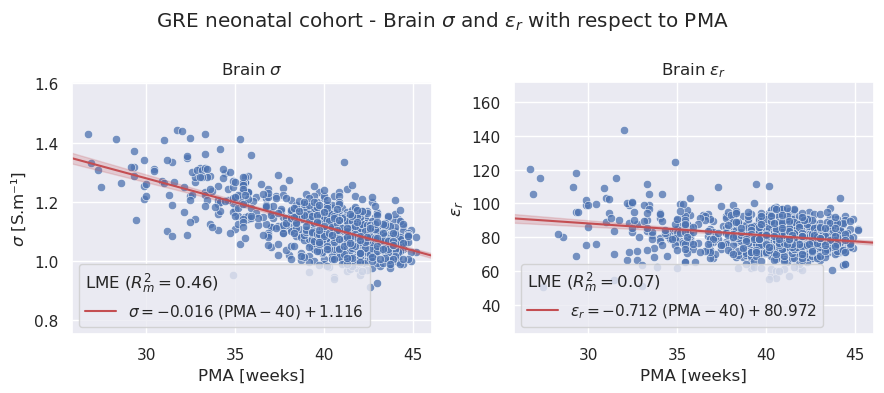

In [5]:
# Set file path
dHCP_df_path = os.path.join(csv_dir, "dHCP_GRE.csv")
plot_path = os.path.join(plot_dir, "experiment1B.png")
summary_path = os.path.join(base_dir, "statsmodels", "experiment1B.txt")

# Load dataframe
df = pd.read_csv(dHCP_df_path)

# Display cohort size
print(f"dHCP sessions n = {len(df.index)}")
print(f"dHCP subjects m = {df['subject_id'].nunique()}")
    
# Data header
x_col = "PMA"
sig_col = "GRE_brain_SIG"
eps_col = "GRE_brain_EPS"
groups_col = "subject_id"
y_cols = [sig_col, eps_col]
x_display_offset = 40

# Axis limit with margin
xlim = calculate_plot_lim(df[x_col], coeff_margin=0.05)
xlim_pred = [xlim[0] - x_display_offset, xlim[1] - x_display_offset]

# Adjust PMA
df[x_col] -= x_display_offset

# Initialize output directories
for path in [summary_path, plot_path]:
    output_dir = os.path.dirname(path)
    os.makedirs(output_dir, exist_ok=True)

# Initialize plot
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
fig.suptitle(r"GRE neonatal cohort - Brain $\sigma$ and $\epsilon_r$ with respect to PMA")

# Iter over EPs
for i, y_col in enumerate(y_cols):

    # Axis limit with margin
    ylim = calculate_plot_lim(df[y_col], coeff_margin=0.3)

    # Fit mixed effects model
    formula = f"{y_col} ~ {x_col}"
    lme = smf.mixedlm(formula, df, groups=df[groups_col]).fit(reml=False)

    # Coefficient of determination
    marginal_r2, conditional_r2 = lme_coefficient_determination(lme, df)

    # Confidence interval
    pred_df = lme_confidence_interval(lme, df, x_col, xlim_pred)

    # Transform X for plotting
    df["x_disp"] = df[x_col] + x_display_offset
    pred_df["x_disp"] = pred_df[x_col] + x_display_offset

    # Plot data
    sns.scatterplot(data=df, x="x_disp", y=y_col, ax=axes[i], alpha=0.75, label=None)

    # Label
    slope = lme.params[x_col]
    intercept = lme.params["Intercept"]
    slope_txt = f"{slope:.3f}"
    coeff_txt = rf"\; (\mathregular{{PMA}} - {x_display_offset})"
    intercept_txt = f"+ {intercept:.3f}" if intercept >= 0 else f"- {abs(intercept):.3f}"
    var_symbol = r"\epsilon_r" if i else r"\sigma"
    label = f"${var_symbol} = {slope_txt}{coeff_txt} {intercept_txt}$"
    
    # Regression line and confidence interval
    axes[i].plot(pred_df["x_disp"], pred_df["Predicted"], color="r", label=label)
    axes[i].fill_between(pred_df["x_disp"], pred_df["CI_lower"], pred_df["CI_upper"], color="r", alpha=0.2)

    # Labels and limits
    axes[i].set_title(f"Brain ${var_symbol}$")
    axes[i].set_xlabel("PMA [weeks]")
    axes[i].set_ylabel(rf"${var_symbol}$ [S.m⁻¹]" if i == 0 else rf"${var_symbol}$")
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)

    # Legend
    leg = axes[i].legend(loc="lower left", title=f"LME ($R^2_m = {marginal_r2:.2f}$)")
    leg._legend_box.align = "left"

    # Write summary
    write_mode = "a" if i else "w"
    with open(summary_path, write_mode) as fh:
        fh.write(lme.summary().as_text())
        fh.write(f"\nMarginal R² = {marginal_r2:.2f}, Conditional R² = {conditional_r2:.2f}\n\n")

# Save plot
fig.tight_layout()
plt.savefig(plot_path, bbox_inches='tight', dpi=300)

In [6]:
# Model summary
f = open(summary_path, 'r')
file_contents = f.read()
print(file_contents)
f.close()

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: GRE_brain_SIG
No. Observations: 868     Method:             ML           
No. Groups:       770     Scale:              0.0034       
Min. group size:  1       Log-Likelihood:     1196.2533    
Max. group size:  3       Converged:          Yes          
Mean group size:  1.1                                      
------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept    1.116     0.002  528.288  0.000   1.112   1.120
PMA         -0.016     0.001  -26.102  0.000  -0.018  -0.015
Group Var    0.000     0.005                                

Marginal R² = 0.46, Conditional R² = 0.50

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: GRE_brain_EPS
No. Observations: 868     Method:             ML           
No. Groups: 

A strong linear dependence of brain $\sigma$ with age was observed within the neonate cohort (marginal coefficient of determination, $R^2_m = 0.46$); $\epsilon_r$ correlates much more weakly with age ($R^2_m = 0.07$) in the same period.